This notebook builds on the findings from the `2_Neural Style Transfer - Optimizer Experiments.ipynb` notebook by experimenting with different loss function settings.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# Getting the Images

In [2]:
# *****************************************************************************
# To get this code to work on your system, you may need to re-write this cell,
# depending on where you plan to run these files from. As you can see, I chose
# to put the files on my Google Drive and run them from there using Google
# Colab. You may choose another approach, such as running files locally.
# *****************************************************************************
from google.colab import drive
drive.mount('/content/drive')

base_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Hinton.jpg"
style_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/GeorgeFloyd.jpg"

Mounted at /content/drive


In [3]:
# Make sure the images are a similar size. Widely differing sizes can make the
# style transfer more difficult.
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [4]:
# Opens, reizes, and converys an image into a numpy array.
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Transform the the array (for use with VGG19 ImageNet).
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Converts a numpy array back into an image.
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Zero-center the values by removing the mean pixel value from ImageNet.
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convert the images from BGR to RGB.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [5]:
base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)

# Make sure that the tensor for the generated image can be changed.
generated_image = tf.Variable(preprocess_image(base_image_path))

# Setting up the Network

In [6]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Choosing the Content and Style Layers

In [7]:
content_layer_name = "block5_conv2"

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Defining the Loss Functions

In [8]:
content_weight = 2.5e-8
style_weight = 1e-6
total_variation_weight = 1e-6

def content_loss(base_img, generated_img):
    # Compute the mean squared error between the two images.
    return tf.reduce_sum(tf.square(generated_img - base_img))

def gram_matrix(x):
    # Compute the Gram matrix.
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, generated_img):
    # Compute the Gram matrices of the style and combination images.
    S = gram_matrix(style_img)
    C = gram_matrix(generated_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    # Compute the total variation loss, which operates on the generated image.
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(generated_image, base_image, style_image, content_weight, style_weight, total_variation_weight):
    input_tensor = tf.concat([base_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss to zero.
    loss = tf.zeros(shape=())

    # Add the content loss.
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, generated_features)

    # Add the style loss.
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_features, generated_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Add the total variation loss.
    loss += total_variation_weight * total_variation_loss(generated_image)
    return loss

# Performing Gradient Descent

array([[[255, 255, 255],
        [246, 255, 255],
        [244, 255, 255],
        ...,
        [246, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[251, 255, 255],
        [236, 255, 255],
        [241, 255, 255],
        ...,
        [241, 255, 247],
        [252, 255, 255],
        [255, 255, 255]],

       [[249, 255, 255],
        [237, 255, 255],
        [245, 255, 249],
        ...,
        [241, 255, 236],
        [244, 255, 250],
        [254, 255, 255]],

       ...,

       [[  0,   0,  42],
        [  0,   0,  49],
        [  0,   0,  53],
        ...,
        [  0,   0,  59],
        [  0,   0,  79],
        [  0,   0,  93]],

       [[  0,   0,  44],
        [  0,   0,  49],
        [  0,   0,  62],
        ...,
        [  0,   0,  72],
        [  0,   0,  86],
        [  0,   0,  76]],

       [[  0,   0,  42],
        [  0,   0,  40],
        [  0,   0,  61],
        ...,
        [  0,   0,  88],
        [  0,   0,  93],
        [  0,   0,   0]]], dtype=uint8)
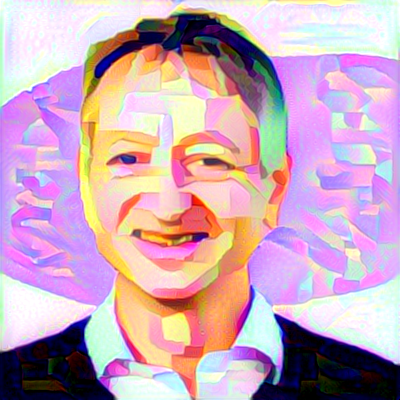

Train step: 4000


In [9]:
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_image, content_weight, style_weight, total_variation_weight):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, base_image, style_image, content_weight, style_weight, total_variation_weight)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

optimizer = keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
    ),
    rho=0.9,
    epsilon=1e-7
)

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, content_weight, style_weight, total_variation_weight)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

This is our new baseline image. It was generated using the RMSProp optimizer with an initial learning rate of 0.1 and an exponential decay schedule. In this notebook, we will experiment with different loss function settings. In particular, we will experiment with different values for the following variables in the loss function:
- `content_weight`
- `style_weight`
- `total_variation_weight`

The above baseline image was generated with the values that Chollet used in his sample code:
- `content_weight = 2.5e-8`
- `style_weight = 1e-6`
- `total_variation_weight = 1e-6`

# Experimenting with Different Weights

array([[[236, 255, 255],
        [232, 255, 255],
        [240, 255, 255],
        ...,
        [253, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[232, 255, 255],
        [233, 255, 255],
        [245, 255, 255],
        ...,
        [252, 255, 255],
        [255, 255, 252],
        [255, 255, 255]],

       [[233, 255, 255],
        [238, 255, 255],
        [251, 255, 255],
        ...,
        [248, 255, 255],
        [249, 255, 251],
        [252, 255, 252]],

       ...,

       [[  0,   0,  41],
        [  0,   0,  38],
        [  0,   0,  26],
        ...,
        [  0,   0,  34],
        [  0,   0,  46],
        [  0,   0,  47]],

       [[  0,   0,  47],
        [  0,   0,  49],
        [  0,   0,  40],
        ...,
        [  0,   0,  52],
        [  0,   0,  65],
        [  0,   0,  73]],

       [[  0,   0,  41],
        [  0,   0,  53],
        [  0,   0,  45],
        ...,
        [  0,   0,  62],
        [  0,   0,  77],
        [  0,   0,  19]]], dtype=uint8)
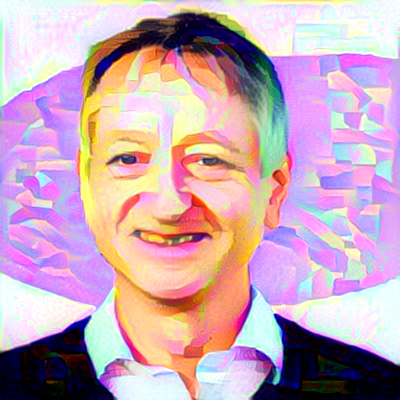

Train step: 4000
Image saved to /content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Loss/content_0.025_style_0.01_tv_0.01.png


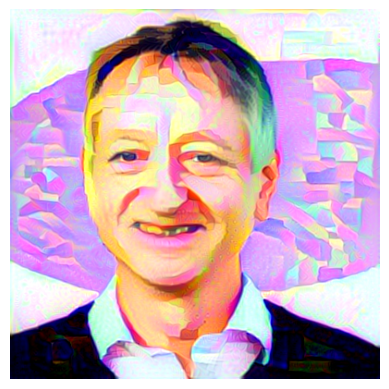

In [10]:
content_weights = [2.5e-10, 2.5e-8, 2.5e-2]
style_weights = [1e-10, 1e-6, 1e-2]
total_variation_weights = [1e-10, 1e-6, 1e-2]

iterations = 4000

for cw in content_weights:
    for sw in style_weights:
        for tvw in total_variation_weights:
            # Reset generated image before each experiment
            generated_image = tf.Variable(preprocess_image(base_image_path))

            # Create a new optimizer for each set of weights
            optimizer = keras.optimizers.RMSprop(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
                ),
                rho=0.9,
                epsilon=1e-7
            )

            for i in range(1, iterations + 1):
                loss, grads = compute_loss_and_grads(generated_image, base_image, style_image, cw, sw, tvw)
                optimizer.apply_gradients([(grads, generated_image)])
                print(".", end='', flush=True)
                if i % 100 == 0:
                    print(f"Iteration {i}: loss={loss:.2f}")
                    img = deprocess_image(generated_image.numpy())
                    display.clear_output(wait=True)
                    display.display(img)
                    print("Train step: {}".format(i))

            # Save the final image
            img = deprocess_image(generated_image.numpy())
            plt.imshow(img)
            plt.axis('off')  # Hide axes

            # Create a unique filename based on the weights
            filename = f"content_{cw}_style_{sw}_tv_{tvw}.png"
            save_path = f"/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Experiments_Loss/{filename}"
            plt.imsave(save_path, img, cmap='gray')
            print(f"Image saved to {save_path}")

# *****************************************************************************
# To get this code to work on your system, you may need to re-write the
# save_path, depending on where you plan to write the generated images. As you
# can see, I chose to write them to the Experiments_Loss directory on my Google
# Drive. You may choose another approach or location.
# *****************************************************************************